In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import sys, glob, copy, os

from utils.plotting.plotting_utils import figSize
from utils.simulation.simulation import simulateBCIFitts
from utils.simulation import simulation_utils
from utils.preprocessing import sweep_utils

from utils.recalibration import RTI_utils, stabilizer_utils, hmm_utils, hmm
from stabilizer_utils import Stabilizer
from hmm import HMMRecalibration
from RTI_utils import RTI

from joblib import Parallel, delayed
import copy

from sklearn.linear_model import LinearRegression

import pandas as pd
from matplotlib import pyplot as plt
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d



## Stabilizer error analysis

Here we'll debug what's going wrong with the stabilizer at two months out. We'll test the three components of the model:
- dimensionality reduction on the reference day
- dimensionality reduction on the final day
- Procrustes realignment on the final day (we're using daisy-chaining here)
                                           
 First let's run our stabilizer models like we did for model comparisons.                        

In [3]:
sweep_dir = '/oak/stanford/groups/henderj/ghwilson/nonstationarities/simulator/performance/instability_analysis2/'
fig_path  = '/home/users/ghwilson/projects/nonstationarities/figures/'


sweep_scores = list()
for file in glob.glob(os.path.join(sweep_dir, '*.npy')):
    sweep_scores.extend(np.load(file, allow_pickle=True))
    
    
for x in sweep_scores:
    x['SNR'] = np.linalg.norm(x['new_cfgs'][0]['neuralTuning'][:, 1:])

### Initial look at sessions

Let's plot the decoder-encoder correlations across our data and their relation to trial times. 

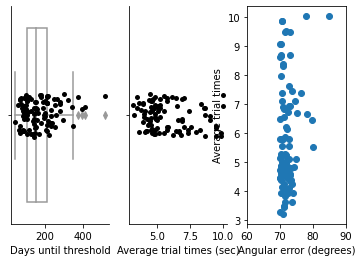

In [4]:
figSize(5, 15)
import seaborn as sns

plt.subplot(1,3,1)
n_days = [x['n_days_to_threshold'][0] for x in sweep_scores]

sns.boxplot(x=n_days,orient='horizontal', color=[1,1,1,0])
sns.stripplot(x=n_days,orient='horizontal', color = 'k')
plt.xlabel('Days until threshold')


plt.subplot(1,3,2)
sns.stripplot(x=[np.mean(x['ttt']) for x in sweep_scores],orient='horizontal', color = 'k')
plt.xlabel('Average trial times (sec)')

plt.subplot(1,3,3)
plt.scatter([x['corrvals'] for x in sweep_scores],[np.mean(x['ttt']) for x in sweep_scores])
plt.xlim([60, 90])
plt.ylabel('Average trial times')
plt.xlabel('Angular error (degrees)')

for i in range(2):
    plt.subplot(1,3,i+1)
    ax = plt.gca()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
save_fname = os.path.join(fig_path, 'simulator')
plt.savefig(os.path.join(save_fname, 'error_analysis_sweep_characteristics.pdf'), format='pdf')

In [10]:
from performance_sweep import performMethodRecal

def getAngularError(encoder, decoder):
    
    return np.arccos(np.corrcoef(encoder.flatten(), decoder.flatten())[0,1])
    


def getErrorAtKDays(sweep_result, method_opts, nSimSteps, n_days = 1, idx = 0):
    
    cfg  = copy.deepcopy(sweep_result['new_cfgs'][0])
    cfg['nSimSteps'] = nSimSteps
    
    # build recalibration object if not already existing (stabilizer only in this case)
    if method_opts['method'] == 'RTI':
        method = RTI(method_opts['look_back'], method_opts['min_dist'], method_opts['min_time'])
        
    elif method_opts['method'] == 'PRI-T':
        adjustKappa             = lambda x: 1 / (1 + np.exp(-1 * (x - method_opts['inflection']) * method_opts['exp']))
        targLocs                = hmm_utils.generateTargetGrid(gridSize = method_opts['gridSize'], is_simulated=True)
        stateTrans, pStateStart = hmm_utils.generateTransitionMatrix(gridSize = method_opts['gridSize'],
                                                                     stayProb = method_opts['stayProb'])

        if method_opts['click_inflection'] is None:
            clickModel = None
        else:
            clickModel = lambda x: 1- (1 / (1 + np.exp(-1 * (x - method_opts['click_inflection'])*12))) 
            
        method = HMMRecalibration(stateTrans, targLocs, pStateStart, method_opts['vmKappa'], 
                                          adjustKappa = adjustKappa, getClickProb = clickModel)
        
    elif method_opts['method'] == 'stabilizer':
        ss_decoder_dict = copy.deepcopy(sweep_result['ss_decoder_dicts'][0])
        stabilizer      = copy.deepcopy(sweep_result['stabilizers'][0])                                
        method          = (ss_decoder_dict, stabilizer, method_opts)
        
    elif method_opts['method'] == 'supervised':
        method = []
                
    existing_error = getAngularError(cfg['D'][1:, :], cfg['neuralTuning'][:, 1:])
    trial_times    = list()
    for _ in range(n_days):
        cfg['neuralTuning'] = simulation_utils.simulateTuningShift(cfg['neuralTuning'], n_stable = 0, PD_shrinkage = 0.91, 
                                                                      mean_shift = 0, renormalize = 0.5)  
        
        
        cfg['D']    = performMethodRecal(cfg, method_opts, method)
        cfg['beta'] = simulation_utils.gainSweep(cfg, possibleGain = np.linspace(0.1,2.5,10))
        
        trial_times.append(simulation_utils.evalOnTestBlock(cfg))

    new_error   = getAngularError(cfg['D'][1:, :], cfg['neuralTuning'][:, 1:])
    
    errors_dict = {
        'method'      : method_opts['method'],
        'trial_times' : trial_times,
        'existing_error' : existing_error,
        'new_error' : new_error,
        'idx'       : idx
    }
    
    if method_opts['method'] == 'PRI-T' and method_opts['click_inflection'] is not None:
        errors_dict['method'] = 'Click PRI-T'

    return errors_dict



In [11]:
# PRI-T settings:
hmm_opts = {
    'method'      : 'PRI-T',
    'probThresh'  : 'probWeighted',
    'gridSize'    : 20,
    'stayProb'    : 0.999,
    'inflection'  : 0.2,
    'exp'         : 1,
    'vmKappa'     : 4,
    'chained'     : True,
    'click_inflection': None
}

clickhmm_opts = {
    'method'      : 'PRI-T',
    'probThresh'  : 'probWeighted',
    'gridSize'    : 20,
    'stayProb'    : 0.999,
    'inflection'  : 0.2,
    'exp'         : 1,
    'vmKappa'     : 4,
    'chained'     : True,
    'click_inflection': 0.1
}

# RTI settings:
rti_opts = {
    'method'    : 'RTI',
    'look_back' : 320,
    'min_dist'  : 0.1,
    'min_time'  : 30,
    'chained'   : True
}

ss_opts = {
    'method' : 'stabilizer',
    'B'      : 190,
    'thresh' : 0.05,
    'n_components' : 4,
    'model_type'   : 'PCA',
    'chained'      : True
} 


supervised_opts = {'method' : 'supervised',
                   'chained' : True}

In [ ]:
from joblib import Parallel, delayed
from sklearn.model_selection import ParameterGrid

n_days         = 5
training_sizes = [1000, 2500, 5000, 10000, 12000, 14000, 16000, 18000, 20000]
method_opts    = [hmm_opts, clickhmm_opts, rti_opts, ss_opts, supervised_opts]

grid = ParameterGrid({'nSimSteps' : training_sizes, 
                      'method_opts' : method_opts,
                      'idx' : np.arange(len(sweep_scores)),
                      'n_days' : [n_days]})

def sweepFunc(cfg):
    errors = getErrorAtKDays(sweep_scores[cfg['idx']], cfg['method_opts'], nSimSteps=cfg['nSimSteps'],
                             n_days=cfg['n_days'], idx=cfg['idx'])
    
    return (errors['method'], cfg['nSimSteps'], errors['existing_error'], errors['new_error'], 
            errors['trial_times'], cfg['idx'])
    

data_sweep = Parallel(n_jobs=-1, verbose = 5)(delayed(sweepFunc)(inputs) for inputs in grid)      

errors_df  = pd.DataFrame(columns=['method','nSimSteps', 'existing_error', 'new_error', 'trial_times', 'idx'])
for errors in data_sweep:
    errors_df.loc[len(errors_df.index)] = errors

errors_df['error_reduction'] = (errors_df['new_error'] - errors_df['existing_error']) / np.abs(errors_df['existing_error'])

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
/home/users/ghwilson/projects/nonstationarities/utils/simulation/simulation.py:299: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float64, 2d, A), array(float64, 2d, C))
  simAct  = getNeuralTuning(currControl, decode_params)
/home/users/ghwilson/projects/nonstationarities/utils/simulation/simulation.py:302: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float64, 2d, A), array(float64, 2d, C))
  rawDecVec = getDecodedControl(simAct, decode_params)
/home/users/ghwilson/projects/nonstationarities/utils/simulation/simulation.py:299: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float64, 2d, A), array(float64, 2d, C))
  simAct  = getNeuralTuning(currControl, decode_params)
/home/users/ghwilson/projects/nonstationarities/utils/simulation/simulation.py:302: NumbaPerformanceWarning: np.dot() is faster on cont

/home/users/ghwilson/projects/nonstationarities/simulator_notebooks/../utils/recalibration/hmm.py:86: RuntimeWarning: divide by zero encountered in log
  obsProbLog  += np.log(clickState[:, None] * probClick + ((1 - clickState)[:, None] * (1 - probClick)))
/home/users/ghwilson/projects/nonstationarities/simulator_notebooks/../utils/recalibration/hmm.py:86: RuntimeWarning: divide by zero encountered in log
  obsProbLog  += np.log(clickState[:, None] * probClick + ((1 - clickState)[:, None] * (1 - probClick)))
/home/users/ghwilson/projects/nonstationarities/simulator_notebooks/../utils/recalibration/hmm.py:86: RuntimeWarning: divide by zero encountered in log
  obsProbLog  += np.log(clickState[:, None] * probClick + ((1 - clickState)[:, None] * (1 - probClick)))
/home/users/ghwilson/projects/nonstationarities/simulator_notebooks/../utils/recalibration/hmm.py:86: RuntimeWarning: divide by zero encountered in log
  obsProbLog  += np.log(clickState[:, None] * probClick + ((1 - clickState)[:

/home/users/ghwilson/projects/nonstationarities/simulator_notebooks/../utils/recalibration/hmm.py:86: RuntimeWarning: divide by zero encountered in log
  obsProbLog  += np.log(clickState[:, None] * probClick + ((1 - clickState)[:, None] * (1 - probClick)))
/home/users/ghwilson/projects/nonstationarities/simulator_notebooks/../utils/recalibration/hmm.py:86: RuntimeWarning: divide by zero encountered in log
  obsProbLog  += np.log(clickState[:, None] * probClick + ((1 - clickState)[:, None] * (1 - probClick)))
/home/users/ghwilson/projects/nonstationarities/simulator_notebooks/../utils/recalibration/hmm.py:86: RuntimeWarning: divide by zero encountered in log
  obsProbLog  += np.log(clickState[:, None] * probClick + ((1 - clickState)[:, None] * (1 - probClick)))
/home/users/ghwilson/projects/nonstationarities/simulator_notebooks/../utils/recalibration/hmm.py:86: RuntimeWarning: divide by zero encountered in log
  obsProbLog  += np.log(clickState[:, None] * probClick + ((1 - clickState)[:

/home/users/ghwilson/projects/nonstationarities/simulator_notebooks/../utils/recalibration/hmm.py:86: RuntimeWarning: divide by zero encountered in log
  obsProbLog  += np.log(clickState[:, None] * probClick + ((1 - clickState)[:, None] * (1 - probClick)))
/home/users/ghwilson/projects/nonstationarities/simulator_notebooks/../utils/recalibration/hmm.py:86: RuntimeWarning: divide by zero encountered in log
  obsProbLog  += np.log(clickState[:, None] * probClick + ((1 - clickState)[:, None] * (1 - probClick)))
/home/users/ghwilson/projects/nonstationarities/simulator_notebooks/../utils/recalibration/hmm.py:86: RuntimeWarning: divide by zero encountered in log
  obsProbLog  += np.log(clickState[:, None] * probClick + ((1 - clickState)[:, None] * (1 - probClick)))
/home/users/ghwilson/projects/nonstationarities/simulator_notebooks/../utils/recalibration/hmm.py:86: RuntimeWarning: divide by zero encountered in log
  obsProbLog  += np.log(clickState[:, None] * probClick + ((1 - clickState)[:

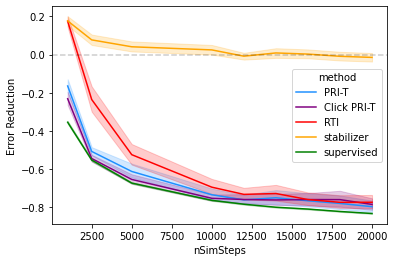

In [14]:
palette = {'stabilizer' : 'orange', 'PRI-T' : 'dodgerblue', 'Click PRI-T' : 'purple',
           'RTI' : 'red', 'supervised' : 'green'}

sns.lineplot(errors_df, x='nSimSteps', y = 'error_reduction', hue = 'method', palette=palette,)
plt.ylabel('Error Reduction')
#plt.xscale('log')

plt.axhline(0, linestyle ='--', color='k', alpha=0.2)
#plt.ylim([-0.1, 0.1])
#plt.ylim([-0.25, 0.25])


save_fname = os.path.join(fig_path, 'simulator')
plt.savefig(os.path.join(save_fname, 'error_analysis_datasize_sweep2.pdf'), format='pdf')

In [18]:
errors_df.nSimSteps.unique() * 0.02

array([ 20.,  50., 100., 200., 240., 280., 320., 360., 400.])

### Plot data

We'll make three comparisons:
- *reference subspace quality*: compare latent decoder on day 0 versus the full neural decoder; if the latent space is a good one these should be similar
- *new subspace quality*: compare a latent decoder on day K versus the full neural decoder
- *Procrustes realignment*: compare unsupervised Procrustes realignment (our stabilizer model) versus a supervised fit where we force day K latent activity into day 0 subspace (the regression to kinematics is fixed)

In [464]:
from sklearn.metrics import r2_score
from scipy.linalg import orthogonal_procrustes

dicts = list()

for i, (ref_cfg, new_cfg) in enumerate(zip(sweep_scores['reference_cfgs'], sweep_scores['new_cfgs'])):
    
    ref_neural_train, ref_kinematics_train = simulation_utils.simulateUnitActivity(ref_cfg['neuralTuning'], noise=0.3, nSteps=ref_cfg['nSimSteps'])
    ref_neural_test, ref_kinematics_test = simulation_utils.simulateUnitActivity(ref_cfg['neuralTuning'], noise=0.3, nSteps=ref_cfg['nSimSteps'])
    
    new_neural_train, new_kinematics_train = simulation_utils.simulateUnitActivity(new_cfg['neuralTuning'], noise=0.3, nSteps=new_cfg['nSimSteps'])
    new_neural_test, new_kinematics_test = simulation_utils.simulateUnitActivity(new_cfg['neuralTuning'], noise=0.3, nSteps=new_cfg['nSimSteps'])
    
    d = dict()
    # test quality of neural activity and subspace on reference day
    d['ref_neural_score'] = LinearRegression().fit(ref_neural_train, ref_kinematics_train).score(ref_neural_test, ref_kinematics_test)
    d['new_neural_score'] = LinearRegression().fit(new_neural_train, new_kinematics_train).score(new_neural_test, new_kinematics_test)
    
    stabilizer = sweep_scores['stabilizers'][i]
    dimreduce  = sweep_scores['ss_decoders'][i]['Q'] #stabilizer.getNeuralToLatentMap(stabilizer.ref_model)
    ref_latent_train = ref_neural_train.dot(dimreduce) #stabilizer.ref_model.transform(ref_neural_train)
    ref_latent_test  = ref_neural_test.dot(dimreduce) #stabilizer.ref_model.transform(ref_neural_test)

    new_latent_train = stabilizer.new_model.transform(new_neural_train)
    new_latent_test  = stabilizer.new_model.transform(new_neural_test)
    
    # test quality of neural activity and subspace on final day
    d['ref_latent_score'] = LinearRegression().fit(ref_latent_train, ref_kinematics_train).score(ref_latent_test, ref_kinematics_test)
    d['new_latent_score'] = LinearRegression().fit(new_latent_train, new_kinematics_train).score(new_latent_test, new_kinematics_test)
    
    d['ref_latent_score'] = LinearRegression().fit(ref_latent_train, ref_kinematics_train).score(ref_latent_test, ref_kinematics_test)
    d['new_latent_score'] = LinearRegression().fit(new_latent_train, new_kinematics_train).score(new_latent_test, new_kinematics_test)
    
    
    # ------------ test quality of Procrustes alignment ------------
    
    # this is equivalent to: (latent_decoder o stabilizer_map)(X_new); 'D' matrix is composition of these
    unsupervised_preds = new_neural_test.dot(new_cfg['D'][1:, :]) + new_cfg['D'][0, :]
    
    # supervised predictions - we do a procrustes on the new latent activity 
    # and the targets in reference latent space; note this works because we can simply invert 
    # the kinematic decoder; for dim_latent > dim_output, you'll need a more involved solver 
    # e.g. could do projected gradient descent (with an orthogonality constraint)
    kinematics_mapped_to_reference = new_kinematics_train.dot(np.linalg.inv(sweep_scores['ss_decoders'][i]['h'].T))
    R, _             = orthogonal_procrustes(new_latent_train, kinematics_mapped_to_reference)
    supervised_preds = new_latent_test.dot(R).dot(sweep_scores['ss_decoders'][i]['h'].T) + sweep_scores['ss_decoders'][i]['lr_intercept'].flatten()
    
    
    d['new_unsupervised_score'] = r2_score(new_kinematics_test, unsupervised_preds)
    d['new_supervised_score']   = r2_score(new_kinematics_test, supervised_preds)
    

    # Now get decoder performance on last day (will use as dependent variable for GLM)
    # we use decoder correlations (instead of trial times) to avoid ceiling/floor artifacts 
    preds = new_neural_test.dot(new_cfg['D'][1:, :]) + new_cfg['D'][0, :]
    d['Y'] = r2_score(new_kinematics_test, preds)
    
    dicts.append(d)

In [465]:
df = pd.DataFrame(dicts)


grps = [['ref_latent_score', 'ref_neural_score'],
        ['new_latent_score', 'new_neural_score'],
       ['new_unsupervised_score', 'new_supervised_score']]


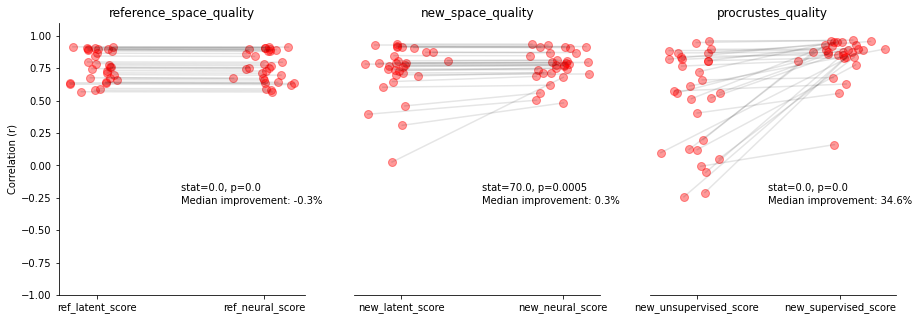

In [466]:
import seaborn as sns
import scipy


colors = ['r', 'b'] * 3
labels = ['reference_space_quality', 'new_space_quality', 'procrustes_quality']

figSize(5, 15)


sm_df = pd.DataFrame(columns=labels + ['Y'])
for i, (grp, label) in enumerate(zip(grps, labels)):
    plt.subplot(1,3,i+1)
    
    xvals  = np.vstack([[0] * df.shape[0], [1] * df.shape[0]]).astype(float)
    xvals += np.random.normal(0, 0.1, size = xvals.shape )
    
    grp1  = df[grp[0]]
    grp2  = df[grp[1]]
    yvals = np.vstack([grp1, grp2])
    sm_df[label] = grp1 - grp2  # save differences for later GLM
    sm_df[label] -= sm_df[label].mean()
    sm_df[label] /= np.std(sm_df[label])
    
    plt.plot(xvals, yvals, c = 'k', alpha = 0.1)
    plt.plot(xvals, yvals, 'o', alpha=.40, zorder=1, ms=8, mew=1, c = 'r')
    
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_ylim([-1, 1.1])
    ax.set_xticks([0, 1], grp)
    
    if i == 0:
        ax.set_ylabel('Correlation (r)')
    else:
        ax.spines['left'].set_visible(False)
        ax.set_yticks([])
        
    test = scipy.stats.wilcoxon(grp1, grp2)
    #print(test)
    plt.text(0.5, -0.2, f'stat={np.round(test[0], 4)}, p={np.round(test[1], 4)}')
    median_improvement = np.median((grp2 - grp1)/ np.abs(grp1))
    plt.text(0.5, -0.3, f'Median improvement: {np.round(100 * median_improvement, 1)}%')
    plt.title(label)
    
fig_path   = '/home/users/ghwilson/projects/nonstationarities/figures/'
save_fname = os.path.join(fig_path, 'simulator', 'stabilizer_error_analysis')
#plt.savefig(save_fname, format = 'pdf')
plt.show()

In [449]:
sm_df['Y'] = df['new_unsupervised_score']

In [438]:
labels

['reference_space_quality', 'new_space_quality', 'procrustes_quality']

In [450]:
import statsmodels.formula.api as smf
import statsmodels.api as sm

#sm_df['Y'] = 
#sm_df['Y'] = 

formula = "Y ~ " + " + ".join(labels) #+ f' + {labels[1]}:{labels[2]}'
mod1    = smf.glm(formula=formula, data=sm_df, family=sm.families.Gaussian()).fit()
print(mod1.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      Y   No. Observations:                   30
Model:                            GLM   Df Residuals:                       26
Model Family:                Gaussian   Df Model:                            3
Link Function:               Identity   Scale:                        0.017219
Method:                          IRLS   Log-Likelihood:                 20.505
Date:                Thu, 17 Aug 2023   Deviance:                      0.44769
Time:                        12:15:16   Pearson chi2:                    0.448
No. Iterations:                     3   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

Text(0, 0.5, 'GLM prediction')

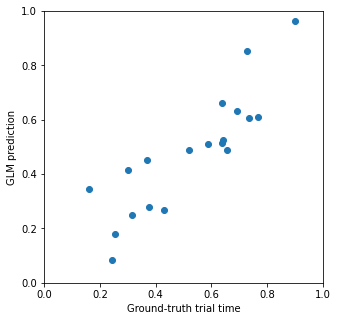

In [451]:
figSize(5, 5)
plt.scatter(sm_df['Y'], mod1.predict())
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('Ground-truth trial time')
plt.ylabel('GLM prediction')